In [52]:
import os
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn

from typing import Optional

from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_ply, load_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex,
    TexturesAtlas,
    TexturesUV
)
from pytorch3d.renderer.blending import (
    hard_rgb_blend,
    BlendParams
)
from pytorch3d.renderer.utils import TensorProperties
from pytorch3d.common import Device
from pytorch3d.renderer.mesh.rasterizer import Fragments
from pytorch3d.ops import interpolate_face_attributes

import chumpy
# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
from plot_image_grid import image_grid

sys.path.append(os.path.abspath('../models/'))
from FLAME import FLAME

In [72]:
def albedo_shading(
    meshes, fragments, lights, cameras, materials, texels
) -> torch.Tensor:
    """
    Apply per pixel shading. First interpolate the vertex normals and
    vertex coordinates using the barycentric coordinates to get the position
    and normal at each pixel. Then compute the illumination for each pixel.
    The pixel color is obtained by multiplying the pixel textures by the ambient
    and diffuse illumination and adding the specular component.

    Args:
        meshes: Batch of meshes
        fragments: Fragments named tuple with the outputs of rasterization
        lights: Lights class containing a batch of lights
        cameras: Cameras class containing a batch of cameras
        materials: Materials class containing a batch of material properties
        texels: texture per pixel of shape (N, H, W, K, 3)

    Returns:
        colors: (N, H, W, K, 3)
    """
    verts = meshes.verts_packed()  # (V, 3)
    faces = meshes.faces_packed()  # (F, 3)
    vertex_normals = meshes.verts_normals_packed()  # (V, 3)
    faces_verts = verts[faces]
    faces_normals = vertex_normals[faces]
    pixel_coords = interpolate_face_attributes(
        fragments.pix_to_face, fragments.bary_coords, faces_verts
    )
    pixel_normals = interpolate_face_attributes(
        fragments.pix_to_face, fragments.bary_coords, faces_normals
    )
    ambient, diffuse, specular = _apply_lighting(
        pixel_coords, pixel_normals, lights, cameras, materials
    )
    colors = texels
    return colors

class HardAlbedoShader(nn.Module):
    """
    Per pixel lighting - the lighting model is applied using the interpolated
    coordinates and normals for each pixel. The blending function hard assigns
    the color of the closest face for each pixel.

    To use the default values, simply initialize the shader with the desired
    device e.g.

    .. code-block::

        shader = HardPhongShader(device=torch.device("cuda:0"))
    """

    def __init__(
        self,
        device: "cpu",
        cameras: Optional[TensorProperties] = None,
        lights: Optional[TensorProperties] = None,
        materials: Optional[Materials] = None,
        blend_params: Optional[BlendParams] = None,
    ) -> None:
        super().__init__()
        self.lights = lights if lights is not None else PointLights(device=device)
        self.materials = (
            materials if materials is not None else Materials(device=device)
        )
        self.cameras = cameras
        self.blend_params = blend_params if blend_params is not None else BlendParams()

    # pyre-fixme[14]: `to` overrides method defined in `Module` inconsistently.
    def to(self, device: Device):
        # Manually move to device modules which are not subclasses of nn.Module
        cameras = self.cameras
        if cameras is not None:
            self.cameras = cameras.to(device)
        self.materials = self.materials.to(device)
        self.lights = self.lights.to(device)
        return self


    def forward(self, fragments: Fragments, meshes: Meshes, **kwargs) -> torch.Tensor:
        cameras = kwargs.get("cameras", self.cameras)
        if cameras is None:
            msg = "Cameras must be specified either at initialization \
                or in the forward pass of HardAlbedoShader"
            raise ValueError(msg)

        texels = meshes.sample_textures(fragments)
        lights = kwargs.get("lights", self.lights)
        materials = kwargs.get("materials", self.materials)
        blend_params = kwargs.get("blend_params", self.blend_params)
        colors = texels
        images = hard_rgb_blend(colors, fragments, blend_params)
        return images

In [73]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [96]:
verts, faces, aux = load_obj("../data/head_template_mesh.obj")
verts = verts[None, ...]
uvcoords = aux.verts_uvs[None, ...]  # (N, V, 2)
uvfaces = faces.textures_idx[None, ...]  # (N, F, 3)
faces = faces.verts_idx[None, ...]

#verts[:,:,2] *= -1

grid = F.affine_grid(torch.eye(2,3).unsqueeze(0), (1, 2, 128, 128)).to(device)
#grid = torch.cat([grid, torch.zeros_like(grid)[..., :1]], dim=-1)
tex = TexturesUV(grid.to(device), uvfaces.to(device), uvcoords.to(device))

mesh = Meshes(
            verts=verts.to(device),
            faces=faces.to(device),
            textures=tex.to(device)
        )

In [97]:
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)));


In [98]:
# Get a batch of viewing angles. 
elev = 0
azim = 0

lights = PointLights(device=device, location=[[0.0, 0.0, 3.0]])

R, T = look_at_view_transform(dist=1.0, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)


raster_settings = RasterizationSettings(
    image_size=128, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardAlbedoShader(
        device=device, 
        cameras=cameras
    )
)

target_images = renderer(mesh, cameras=cameras)


In [99]:
R

tensor([[[-1.,  0.,  0.],
         [ 0.,  1.,  0.],
         [ 0.,  0., -1.]]])

In [100]:
T

tensor([[-0., -0., 1.]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


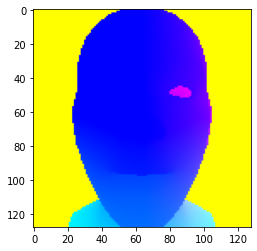

In [101]:
plt.imshow(target_images.cpu()[0, ..., :3])

In [102]:
target_images.shape

torch.Size([1, 128, 128, 3])